# Generate new continua

In [1]:
# Load QPQ9, do a qpqsp.spec_from_coord search, if return is not None,  
# plot with continuum, prompt for generating new continuum, launch continuum fitting GUI, 
# save to a file 
# import
from specdb.specdb import SpecDB, IgmSpec
from astropy import units as u
from astropy.io import fits
from astropy.coordinates import SkyCoord
from xastropy.xutils import fits as xxf
import linetools.utils as ltu
import numpy as np
import warnings
import linetools.spectra.xspectrum1d as lsx
import pdb,os.path
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

In [3]:
# Load QPQ9 
QPQ9 = xxf.bintab_to_table('/Users/lwymarie/python/enigma/enigma/data/qpq/qpq9_final.fits')
# Load QPQ database
qpq_fil = '/Users/lwymarie/Documents/Databases/qpq_oir_spec.hdf5'
qpqsp = SpecDB(db_file=qpq_fil,verbose=False,idkey='QPQ_ID')
igmsp = IgmSpec(version="02.1")

x.fits.bintab_to_table: Reading /Users/lwymarie/python/enigma/enigma/data/qpq/qpq9_final.fits
Database is QPQ
Created on 2017-Jan-31
Loading igmspec from /Users/lwymarie/Documents/Databases/IGMspec_DB_v02.1.hdf5
Database is igmspec
Created on 2017-Sep-18


In [10]:
radec = '144429.40+311321.2'

In [ ]:
skip_records = 0
for ii,qq in enumerate(QPQ9):
    if ii < skip_records:
        continue
    if (ltu.radec_to_coord(radec)).separation(SkyCoord(qq['RA']*u.deg,qq['DEC']*u.deg)) >= 1*u.arcsec:
        continue
    specs,metas = qpqsp.spectra_from_coord((qq['RA']*u.deg,qq['DEC']*u.deg),verbose=False)
    print(metas)
    if metas is not None:
        for ss,meta in enumerate(metas):
            # Check if continuum file already exists
            conti_path = '/Users/lwymarie/Dropbox/Marie_X/QPQ9/Continua/QPQ/data/'
            ipos1 = meta['SPEC_FILE'].rfind('data/')+5
            ipos2 = meta['SPEC_FILE'].rfind('.fits')
            if ipos2 == -1: # filename not in standard format 
                pdb.set_trace()
            if 'BOSS' in meta['SPEC_FILE'][0]:
                outfil = conti_path + meta['SPEC_FILE'][ipos1:ipos2] + '_c.fits'
            else:
                outfil = conti_path + meta['SPEC_FILE'][ipos1:ipos2] + '_c.fits.gz'
            if os.path.isfile(outfil):
                continue
            # Inspect continuum 
            %matplotlib inline
            specs[ss].plot()
            print(SkyCoord(meta['RA_GROUP']*u.deg,meta['DEC_GROUP']*u.deg).to_string('hmsdms'))
            fit_conti = raw_input('Fit continuum? y/n ')
            if fit_conti == 'n':
                continue
            # Fit continuum
            !rm -f _knots.jsn
            specs[ss].co = None
            %pylab
            specs[ss].fit_continuum(kind='QSO',redshift=qq['BG_Z'])
            prihdu = fits.PrimaryHDU(specs[ss].co.value)
            # Save continuum to file 
            hdu = fits.HDUList([prihdu])
            hdu.writeto(outfil,clobber=True)
            print('Saved to:',outfil)

In [6]:
# Load igmspec database
skip_records = 0
for ii,qq in enumerate(QPQ9):
    # Skip if less than this 
    if ii < skip_records:
        continue
    # Skip J1249, not yet fluxed and ingested 
    if SkyCoord(qq['RA']*u.deg,qq['DEC']*u.deg).separation(SkyCoord('12h49m48.09s +06d07m09.2s')) < 0.5*u.arcsec:
        continue
    # Skip if in QPQ database
    specs,metas = qpqsp.spectra_from_coord((qq['RA']*u.deg,qq['DEC']*u.deg),verbose=False)
    if metas is not None:
        continue
    specs,metas = igmsp.spectra_from_coord((qq['RA']*u.deg,qq['DEC']*u.deg),verbose=False)
    print(SkyCoord(qq['RA']*u.deg,qq['DEC']*u.deg).to_string('hmsdms'))
    for ss,meta in enumerate(metas):
        # Check if continuum file already exists
        conti_path = '/Users/lwymarie/Dropbox/Marie_X/QPQ9/Continua/igmspec/'
        ipos1 = 0
        fileext = '.fits.gz'
        ipos2 = meta['SPEC_FILE'][0].rfind(fileext)
        if ipos2 == -1: 
            fileext = '.fit.gz'
            ipos2 = meta['SPEC_FILE'][0].rfind(fileext)
        if ipos2 == -1: # filename not in standard format
            pdb.set_trace()
        outfil = conti_path + meta['SPEC_FILE'][0][ipos1:ipos2] + '_c'+fileext
        if os.path.isfile(outfil):
            continue
        # Inspect continuum 
        %matplotlib inline
        specs[ss].plot()
        print('CII lies in',np.rint(1334.5323*(1+ltu.z_from_v(qq['Z_FG'],-3000))),'to',
              np.rint(1334.5323*(1+ltu.z_from_v(qq['Z_FG'],3000))),
              'MgII lies in',np.rint(2796.352*(1+ltu.z_from_v(qq['Z_FG'],-3000))),'to',
              np.rint(2796.352*(1+ltu.z_from_v(qq['Z_FG'],3000))))
        fit_conti = raw_input('Fit continuum? y/n ')
        if fit_conti == 'n':
            continue
        # Fit continuum
        !rm -f _knots.jsn
        specs[ss].co = None
        %pylab
        specs[ss].fit_continuum(kind='QSO',redshift=qq['BG_Z'])
        prihdu = fits.PrimaryHDU(specs[ss].co.value)
        # Save continuum to file 
        hdu = fits.HDUList([prihdu])
        hdu.writeto(outfil,clobber=True)
        print('Saved to:',outfil)

# Generate continua for foreground quasars 

Staged 1 spectra totalling 8.4e-05 Gb
Loaded spectra
14h44m29.4s +31d13m21.2s


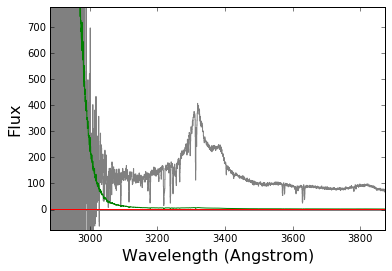

('CII lies in', 3614.0, 'to', 3687.0, 'CIV lies in', 4193.0, 'to', 4278.0, 'MgII lies in', 7573.0, 'to', 7726.0)


In [ ]:
# Only for z > 1.6
high_z = np.where(QPQ9['Z_FG'] > 1.6)[0]
skip_records = 70
for ii,qq in enumerate(QPQ9[high_z]):
    # Skip if less than this 
    if ii < skip_records:
        continue
    specs,metas = qpqsp.spectra_from_coord((qq['FG_RA']*u.deg,qq['FG_DEC']*u.deg),verbose=False)
    if metas is None:
        specs,metas = igmsp.spectra_from_coord((qq['FG_RA']*u.deg,qq['FG_DEC']*u.deg),verbose=False)
        if metas is None:
            continue
        for ss,meta in enumerate(metas):
            print(SkyCoord(meta['RA_GROUP']*u.deg,meta['DEC_GROUP']*u.deg).to_string('hmsdms'))
            conti_path = '/Users/lwymarie/Dropbox/Marie_X/QPQ9/Continua/igmspec/'
            ipos1 = 0
            fileext = '.fit.gz'
            ipos2 = meta['SPEC_FILE'].rfind(fileext)
            if ipos2 == -1:
                fileext = '.fits.gz'
                ipos2 = meta['SPEC_FILE'].rfind(fileext)
            if ipos2 == -1:
                pdb.set_trace()
            outfil = conti_path + meta['SPEC_FILE'][ipos1:ipos2]+'_c'+fileext
            if os.path.isfile(outfil):
                continue
            covered = 0
            if ((meta['WV_MAX'] > 2796.352*(1+ltu.z_from_dv(3000*u.km/u.s,qq['Z_FG']))) & 
                (meta['WV_MIN'] < 2796.352*(1+ltu.z_from_dv(-3000*u.km/u.s,qq['Z_FG'])))):
                covered = 1
            if ((meta['WV_MAX'] > 1548.195*(1+ltu.z_from_dv(3000*u.km/u.s,qq['Z_FG']))) & 
                (meta['WV_MIN'] < 1548.195*(1+ltu.z_from_dv(-3000*u.km/u.s,qq['Z_FG'])))):
                covered = 1
            if ((meta['WV_MAX'] > 1334.5323*(1+ltu.z_from_dv(3000*u.km/u.s,qq['Z_FG']))) & 
                (meta['WV_MIN'] < 1334.5323*(1+ltu.z_from_dv(-3000*u.km/u.s,qq['Z_FG'])))):
                covered = 1
            if covered == 0:
                continue
            %matplotlib inline
            specs[ss].plot()
            print('CII lies in',np.rint(1334.5323*(1+ltu.z_from_dv(-3000*u.km/u.s,qq['Z_FG']))),'to',
                  np.rint(1334.5323*(1+ltu.z_from_dv(3000*u.km/u.s,qq['Z_FG']))),
                  'CIV lies in',np.rint(1548.195*(1+ltu.z_from_dv(-3000*u.km/u.s,qq['Z_FG']))),'to',
                  np.rint(1548.195*(1+ltu.z_from_dv(3000*u.km/u.s,qq['Z_FG']))),
                  'MgII lies in',np.rint(2796.352*(1+ltu.z_from_dv(-3000*u.km/u.s,qq['Z_FG']))),'to',
                  np.rint(2796.352*(1+ltu.z_from_dv(3000*u.km/u.s,qq['Z_FG']))))
            fit_conti = raw_input('Fit continuum? y/n ')
            if fit_conti == 'n':
                continue
            !rm -f _knots.jsn
            specs[ss].co = None
            %pylab
            specs[ss].fit_continuum(kind='QSO',redshift=qq['Z_FG'])
            prihdu = fits.PrimaryHDU(specs[ss].co.value) 
            hdu = fits.HDUList([prihdu])
            hdu.writeto(outfil,clobber=True)
            print('Saved to:',outfil)
    else:
#        continue # skip doing QPQ continua, done alraedy
        for ss,meta in enumerate(metas):
            print(SkyCoord(meta['RA_GROUP']*u.deg,meta['DEC_GROUP']*u.deg).to_string('hmsdms'))
            # Check if continuum file already exists
            conti_path = '/Users/lwymarie/Dropbox/Marie_X/QPQ9/Continua/QPQ/data/'
            ipos1 = meta['SPEC_FILE'].rfind('data/')+5
            fileext = '.fits.gz'
            ipos2 = meta['SPEC_FILE'].rfind(fileext)
            if ipos2 == -1: 
                fileext = '.fit.gz'
                ipos2 = meta['SPEC_FILE'].rfind(fileext)
            if ipos2 == -1:
                fileext = '.fits'
                ipos2 = meta['SPEC_FILE'].rfind(fileext)
            if ipos2 == -1: # filename not in standard format
                pdb.set_trace()
            outfil = conti_path + meta['SPEC_FILE'][ipos1:ipos2] + '_c'+fileext
            if os.path.isfile(outfil):
                continue
            # check if CII, CIV, MgII at z_fg is covered 
            covered = 0
            if ((meta['WV_MAX'] > 2796.352*(1+ltu.z_from_dv(3000*u.km/u.s,qq['Z_FG']))) & 
                (meta['WV_MIN'] < 2796.352*(1+ltu.z_from_dv(-3000*u.km/u.s,qq['Z_FG'])))):
                covered = 1
            if ((meta['WV_MAX'] > 1548.195*(1+ltu.z_from_dv(3000*u.km/u.s,qq['Z_FG']))) & 
                (meta['WV_MIN'] < 1548.195*(1+ltu.z_from_dv(-3000*u.km/u.s,qq['Z_FG'])))):
                covered = 1
            if ((meta['WV_MAX'] > 1334.5323*(1+ltu.z_from_dv(3000*u.km/u.s,qq['Z_FG']))) & 
                (meta['WV_MIN'] < 1334.5323*(1+ltu.z_from_dv(-3000*u.km/u.s,qq['Z_FG'])))):
                covered = 1
            if covered == 0:
                continue
            # Inspect continuum 
            %matplotlib inline
            specs[ss].plot()
            print('CII lies in',np.rint(1334.5323*(1+ltu.z_from_dv(-3000*u.km/u.s,qq['Z_FG']))),'to',
                  np.rint(1334.5323*(1+ltu.z_from_dv(3000*u.km/u.s,qq['Z_FG']))),
                  'CIV lies in',np.rint(1548.195*(1+ltu.z_from_dv(-3000*u.km/u.s,qq['Z_FG']))),'to',
                  np.rint(1548.195*(1+ltu.z_from_dv(3000*u.km/u.s,qq['Z_FG']))),
                  'MgII lies in',np.rint(2796.352*(1+ltu.z_from_dv(-3000*u.km/u.s,qq['Z_FG']))),'to',
                  np.rint(2796.352*(1+ltu.z_from_dv(3000*u.km/u.s,qq['Z_FG']))))
            fit_conti = raw_input('Fit continuum? y/n ')
            if fit_conti == 'n':
                continue
            # Fit continuum
            !rm -f _knots.jsn
            specs[ss].co = None
            %pylab
            specs[ss].fit_continuum(kind='QSO',redshift=qq['Z_FG'])
            prihdu = fits.PrimaryHDU(specs[ss].co.value)
            # Save continuum to file 
            hdu = fits.HDUList([prihdu])
            hdu.writeto(outfil,clobber=True)
            print('Saved to:',outfil)

In [4]:
# for examining continua
radec = '081420.38 +325016.1'
specs,metas = qpqsp.spectra_from_coord(radec,verbose=False)
if metas is not None:
    print('in QPQ')
    for ss,meta in enumerate(metas):
        print('CII at z_em',(1+meta['zem_GROUP'])*1334.5323)
        print('CIV at z_em',(1+meta['zem_GROUP'])*1548.195)
        print('MgII at z_em',(1+meta['zem_GROUP'])*2796.354)
        conti_path = '/Users/lwymarie/Dropbox/Marie_X/QPQ9/Continua/QPQ/data/'
        ipos1 = meta['SPEC_FILE'].rfind('data/')+5
        fileext = '.fits.gz'
        ipos2 = meta['SPEC_FILE'].rfind(fileext)
        if ipos2 == -1: 
            fileext = '.fit.gz'
            ipos2 = meta['SPEC_FILE'].rfind(fileext)
        if ipos2 == -1:
            fileext = '.fits'
            ipos2 = meta['SPEC_FILE'].rfind(fileext)
        if ipos2 == -1: # filename not in standard format
            pdb.set_trace()
        cfil = conti_path + meta['SPEC_FILE'][ipos1:ipos2]+'_c'+fileext
        if os.path.isfile(cfil):
            print(cfil)
            conti = fits.open(cfil)[0].data
            specs[ss].co = conti
        specs[ss].plot()
    
specs,metas = igmsp.spectra_from_coord(radec,verbose=False)
if metas is not None:
    print('in igmspec')
    for ss,meta in enumerate(metas):
        print('CII at z_em',(1+meta['zem_GROUP'])*1334.5323)
        print('CIV at z_em',(1+meta['zem_GROUP'])*1548.195)
        print('MgII at z_em',(1+meta['zem_GROUP'])*2796.354)
        conti_path = '/Users/lwymarie/Dropbox/Marie_X/QPQ9/Continua/igmspec/'
        ipos1 = 0
        fileext = '.fit.gz'
        ipos2 = meta['SPEC_FILE'].rfind(fileext)
        if ipos2 == -1:
            fileext = '.fits.gz'
            ipos2 = meta['SPEC_FILE'].rfind(fileext)
        if ipos2 == -1:
            pdb.set_trace()
        cfil = conti_path + meta['SPEC_FILE'][ipos1:ipos2]+'_c'+fileext
        if os.path.isfile(cfil):
            print(cfil)
            conti = fits.open(cfil)[0].data
            specs[ss].co = conti
        specs[ss].plot()

Staged 1 spectra totalling 0.00016 Gb
Loaded spectra
in QPQ
('CII at z_em', 4287.8522799000002)
('CIV at z_em', 4974.3505349999996)
('MgII at z_em', 8984.6854019999992)


In [4]:
specs,metas = qpqsp.spectra_from_coord(radec,verbose=False)
metas

Staged 1 spectra totalling 0.0001 Gb
Loaded spectra
Staged 1 spectra totalling 0.00016 Gb
Loaded spectra
Staged 1 spectra totalling 2.4e-05 Gb
Loaded spectra


RA_GROUP,DEC_GROUP,STYPE,zem_GROUP,sig_zem,flag_zem,IGM_ID,DATE-OBS,R,DISPERSER,TELESCOPE,INSTR,EPOCH,GROUP_ID,QPQ_ID,NPIX,WV_MIN,WV_MAX,SPEC_FILE,GROUP,VERSION
float64,float64,str3,float64,float64,str8,int64,str10,float64,str12,str12,str6,float64,int64,int64,int64,float64,float64,str86,str4,str7
123.5816,32.8385,QSO,2.174,0.0,QPQ,51317,2004-11-18,1872.0,B1200+_G5301,Gemini-North,GMOS-N,2000.0,11,226,3215,3377.4,4881.1,/u/xavier/Dropbox//QSOPairs/data/GMOS_redux//./SDSSJ081419.59+325018.7_b1200_F.fits.gz,GMOS,--
123.5816,32.8385,QSO,2.171,0.0,BOSS_PCA,51317,2000-01-01,2100.0,BOTH,SDSS 2.5-M,BOSS,2000.0,227,226,4616,3570.3,10332.4,/u/xavier/Dropbox//QSOPairs/data/BOSS/v5_5_0/SDSSJ081419.58+325018.7.fits,BOSS,v5_5_0
123.5816,32.8385,QSO,2.171,0.0,BOSS_PCA,51317,2006-03-06,940.0,Hgrism_G5203,Gemini-North,NIRI,2000.0,3,226,1023,14066.1,19364.9,/u/xavier/Dropbox//QSOPairs/data/NIRI_redux//./SDSSJ081419.58+325018.7.fits,NIRI,--


In [13]:
specs[0].co_is_set

True

4235.9699